In [1]:
#!/usr/bin/env python
'''
DESCRIPTION
-----------
    Encoding information
# 
RETURN
------
    {EXPERIMENT}_enc.png : png file
        graph


EXPORTED FILE(s) LOCATION
-------------------------
    ./reports/encoding/{EXPERIMENT}/{DESING}_enc.png
'''

# importing default libraries
SEED=91
# to get reproducible results
import os, argparse, sys
import tensorflow as tf
tf.random.set_seed(SEED)
import numpy as np
np.random.seed(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)
# importing scripts in scripts folder
from scripts import config as src

**** scripts/config.py IMPORTED!!!
**** PROJECT FOLDER ,  /home/pgundogdu/projects/signalization_prior_knowledge_based_nn


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from tensorflow import keras

FIGURE_TITLE_SIZE = 18
SUBPLOT_TITLE_SIZE = 14
LEGEND_TITLE_SIZE = 12
FONT_SIZE = 10

plt.rc('font', size=FONT_SIZE)                # controls default text sizes
plt.rc('axes', titlesize=SUBPLOT_TITLE_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('legend', title_fontsize=LEGEND_TITLE_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FIGURE_TITLE_SIZE)  # fontsize of the figure title

## MELANOMA

In [3]:
# loc = './reports/encoding/exper_melanoma'
split = 'train_test_split'
experiment = 'exper_melanoma'
loc_read = glob.glob(os.path.join(src.DIR_MODELS, experiment, f'{split}*'))[0]

df_unseen = pd.read_pickle('./data/processed/exper_melanoma/query_log1p.pck')
# df = df[df['cell_type']!='Neg.cell'].reset_index(drop=True)
X_unseen = df_unseen.iloc[:, :-1].values
y_ground_truth_unseen = df_unseen.iloc[:, -1:]


df_seen = pd.read_pickle('./data/processed/exper_melanoma/reference_log1p.pck')
# df = df[df['cell_type']!='Neg.cell'].reset_index(drop=True)
X_seen = df_seen.iloc[:, :-1].values
y_ground_truth_seen = df_seen.iloc[:, -1:]


print('shape of feature and traget dataset, feature dataset, {0}, target column {1}'.format(X_unseen.shape, y_ground_truth_unseen.shape))
print('shape of feature and traget dataset, feature dataset, {0}, target column {1}'.format(X_seen.shape, y_ground_truth_seen.shape))

shape of feature and traget dataset, feature dataset, (3412, 17994), target column (3412, 1)
shape of feature and traget dataset, feature dataset, (2761, 17994), target column (2761, 1)


In [4]:
order_plot = list(np.unique(y_ground_truth_seen))
seen_label = dict(zip(order_plot, range(len(order_plot))))
order_plot.append('Neg.cell')
unseen_label = dict(zip(order_plot, range(len(order_plot))))
print(seen_label)
print(unseen_label)
# seen_label.keys()

{'B.cell': 0, 'Macrophage': 1, 'NK': 2, 'T.CD4': 3, 'T.CD8': 4}
{'B.cell': 0, 'Macrophage': 1, 'NK': 2, 'T.CD4': 3, 'T.CD8': 4, 'Neg.cell': 5}


In [5]:
print(glob.glob(os.path.join(loc_read, f'encoding*1_layer*'))[0])
model = keras.models.load_model( glob.glob(os.path.join(loc_read, f'encoding*1_layer*'))[0] , compile=False)

/home/pgundogdu/projects/signalization_prior_knowledge_based_nn/models/exper_melanoma/train_test_split_tuningFalse_filtergeneFalse/encoding_pathway_signaling_1_layer_reference_log1p_Adam_relu.h5


In [6]:
df_encoding_seen = pd.DataFrame(model.predict(X_seen))
df_encoding_seen['cell_type'] = y_ground_truth_seen
df_encoding_seen['dataset'] = 'training'
df_encoding_unseen = pd.DataFrame(model.predict(X_unseen))
df_encoding_unseen['cell_type'] = y_ground_truth_unseen
df_encoding_unseen['dataset'] = 'testing'

df_encoding = pd.concat([df_encoding_seen, df_encoding_unseen]).reset_index(drop=True)

encoding_all = np.array(df_encoding.iloc[:, :-2])
tsne = TSNE().fit_transform(encoding_all)

df_encoding = pd.concat([pd.DataFrame(tsne, columns=['tsne1', 'tsne2']), df_encoding.iloc[:, -2:]], axis=1)
df_encoding

tsne1      tsne2 cell_type   dataset
0    -20.648951 -46.114113    B.cell  training
1     -3.472789 -73.803719    B.cell  training
2      0.611341 -83.550331    B.cell  training
3    -22.157711 -46.127113    B.cell  training
4     -6.275756 -60.974007    B.cell  training
...         ...        ...       ...       ...
6168 -13.647277  68.083435     T.CD8   testing
6169 -32.835835  53.935738     T.CD8   testing
6170 -10.980044   6.494927     T.CD8   testing
6171 -25.181725  63.179657     T.CD8   testing
6172 -24.024555  55.193836     T.CD8   testing

[6173 rows x 4 columns]

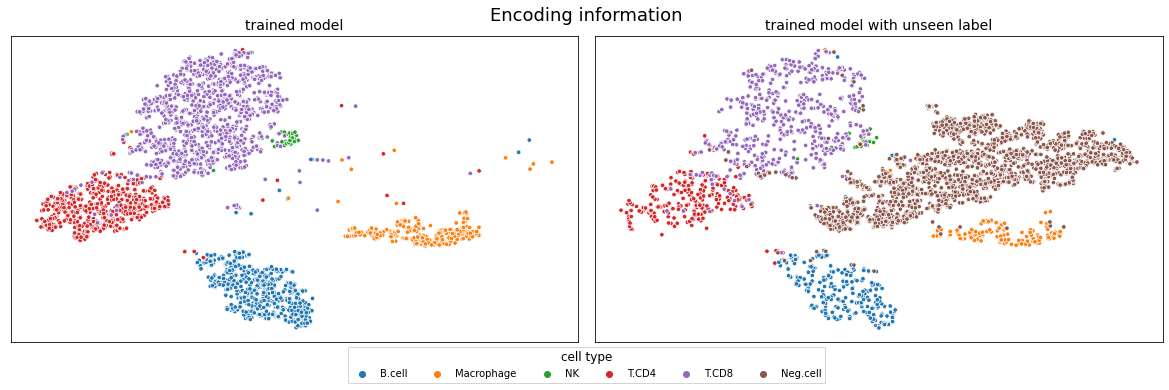

In [7]:
np.random.seed(SEED)
fig, axes= plt.subplots(ncols=2, figsize=(20,5))

df_encoding_tsne_seen = df_encoding[df_encoding['dataset']=='training'].iloc[:, :-1]
df_encoding_tsne_seen = df_encoding_tsne_seen.sort_values(by=['cell_type'], key=lambda x: x.map(seen_label))
df_encoding_tsne_unseen = df_encoding[df_encoding['dataset']=='testing'].iloc[:, :-1]
df_encoding_tsne_unseen = df_encoding_tsne_unseen.sort_values(by=['cell_type'], key=lambda x: x.map(seen_label))

sns.scatterplot(data=df_encoding_tsne_seen, x='tsne1', y='tsne2', hue='cell_type', ax=axes[0], marker='.', s=80)
sns.scatterplot(data=df_encoding_tsne_unseen, x='tsne1', y='tsne2', hue='cell_type', ax=axes[1], marker='.', s=80)

axes[0].get_legend().remove()
axes[0].set_title(f'trained model')


axes[1].get_legend().remove()
axes[1].set_title(f'trained model with unseen label')

axes[0].axes.get_yaxis().set_visible(False)
axes[0].axes.get_xaxis().set_visible(False)

axes[1].axes.get_yaxis().set_visible(False)
axes[1].axes.get_xaxis().set_visible(False)

handles, labels = axes[1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper center', title='cell type', bbox_to_anchor=(.5, 0.05)
                 , fancybox=False, shadow=False, ncol=6)
fig.suptitle(f'Encoding information')
plt.subplots_adjust(left=0.1,
                        bottom=0.05, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.03, 
                        hspace=.4);

# plt.savefig(f'./reports/encoding/{experiment}/ECCB_encoding.png', dpi=300, bbox_inches = 'tight')
# plt.savefig(f'./reports/encoding/{experiment}/ECCB_encoding.pdf', dpi=300, bbox_inches = 'tight')
# plt.savefig(f'./reports/encoding/{experiment}/ECCB_encoding.svg', dpi=300, bbox_inches = 'tight')

# plt.savefig(f'./reports/encoding/{experiment}/mel_enc.png', dpi=300, bbox_inches = 'tight')
# plt.savefig(f'./reports/encoding/{experiment}/mel_enc.pdf', dpi=300, bbox_inches = 'tight')
# plt.savefig(f'./reports/encoding/{experiment}/mel_enc.svg', dpi=300, bbox_inches = 'tight')

In [ ]:
del(df_encoding_seen, df_encoding_tsne_seen)
del(df_encoding_unseen, df_encoding_tsne_unseen)
del(df_encoding, encoding_all)
del(X, y_ground_truth)
del(split, experiment, loc_read)

## MOUSE

In [46]:
split = 'train_test_split'
experiment = 'exper_mouse'
loc_read = os.path.join(src.DIR_MODELS, experiment, split)

df_retrieval_org = pd.read_pickle('./data/external/exper_mouse/3-33_integrated_retrieval_set.pck')
print(df_retrieval_org.shape)
df_retrieval_org.head()

df_retrieval = pd.read_pickle('./data/processed/exper_mouse/mouse_retrieval_sw_gw_cv.pck')
df_retrieval = pd.merge(left=df_retrieval, right=df_retrieval_org[['Label']], left_index=True, right_index=True, how='left')
print(df_retrieval.shape)
df_retrieval.head()


X = df_retrieval.iloc[:, :-2].values
y_ground_truth = df_retrieval.iloc[:, -2]

print('shape of feature and traget dataset, feature dataset, {0}, target column {1}'.format(X.shape, y_ground_truth.shape))

(17293, 9438)
(13645, 9439)
shape of feature and traget dataset, feature dataset, (13645, 9437), target column (13645,)


/home/pgundogdu/projects/signalization_prior_knowledge_based_nn/models/exper_mouse/train_test_split/encoding_1_layer_signaling_mouse_learning_sw_gw_Adam_relu.h5
1_layer
/home/pgundogdu/projects/signalization_prior_knowledge_based_nn/models/exper_mouse/train_test_split/encoding_2_layer_signaling_mouse_learning_sw_gw_Adam_relu.h5
2_layer


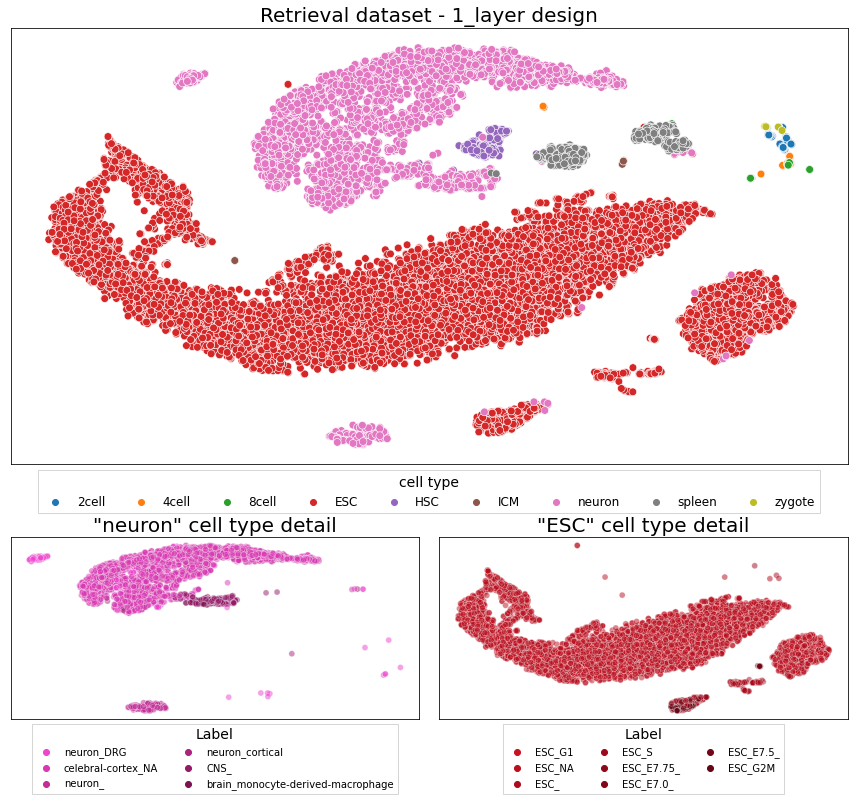

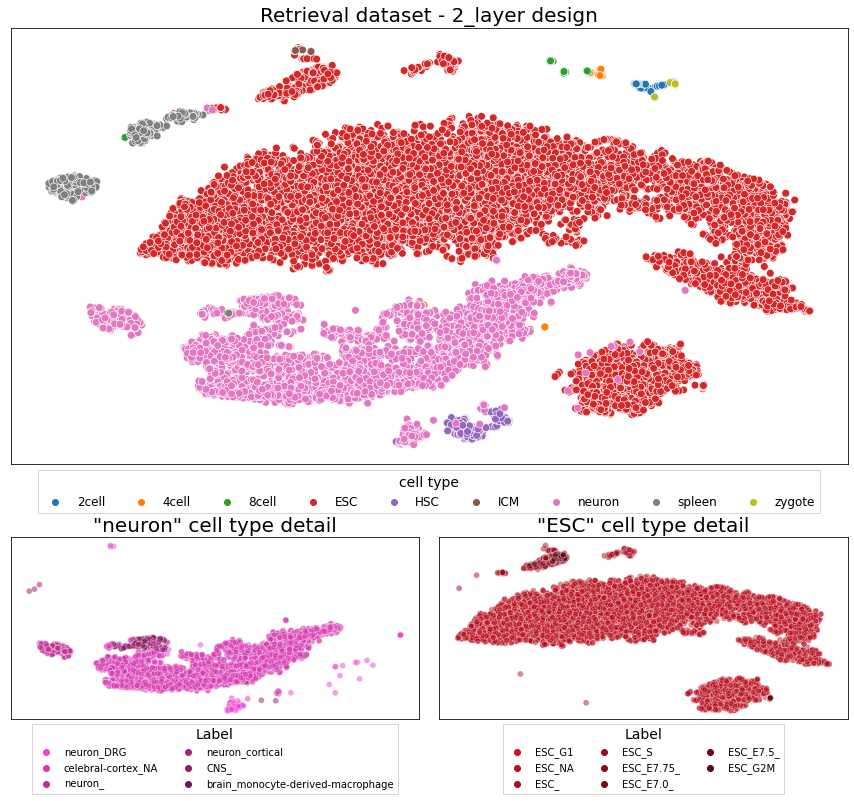

In [48]:
np.random.seed(SEED)
pink_color=['#ee44ce','#d838b2','#c22d97','#ab237e','#931a67','#7c1252']
red_color=['#ca111f','#bb0e1e','#ac0b1d','#9d091c','#8f081a','#800718','#720616','#640614']

for i_design in ['1_layer','2_layer']:

    print(glob.glob(os.path.join(loc_read, f'encoding_{i_design}*'))[0])
    model = keras.models.load_model( glob.glob(os.path.join(loc_read, f'encoding_{i_design}*'))[0] , compile=False)
    encoding = model.predict(X)
    print(i_design)
    
    encoding = model.predict(X)
    tsne = TSNE().fit_transform(encoding)

    df_encoding_tsne = df_encoding_tsne = pd.concat([pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])
                                  , pd.DataFrame(np.array(y_ground_truth),columns=['cell_type'])], axis=1)
    sorter_index=dict(zip(sorted(set(df_retrieval['cell_type'])), range(len(set(df_retrieval['cell_type']))) ))
    df_encoding_tsne['order'] = df_encoding_tsne['cell_type'].map(sorter_index)
    df_encoding_tsne['Label'] = df_retrieval['Label'].values
    df_encoding_tsne
    
    
    fig = plt.figure(figsize=(15,12))
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2, rowspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0), colspan=1)
    ax5 = plt.subplot2grid((3, 2), (2, 1), colspan=1)

    sns.scatterplot(data=df_encoding_tsne.sort_values(by='order')
                    , x='tsne1', y='tsne2', hue='cell_type', ax=ax1, alpha=1., s=60)
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), title='cell type', fancybox=False, shadow=False, ncol=len(y_ground_truth.unique()));

    sns.scatterplot(data=df_encoding_tsne.loc[df_encoding_tsne['cell_type'].isin(['neuron'])].sort_values(by='order')
                    , x='tsne1', y='tsne2', hue='Label', ax=ax3, alpha=.5, marker="o", palette=pink_color)
    ax3.legend(loc='upper center', bbox_to_anchor=(.5, 0.0), title='Label', fancybox=False, shadow=False, ncol=2, fontsize=SMALL_SIZE)

    sns.scatterplot(data=df_encoding_tsne.loc[df_encoding_tsne['cell_type'].isin(['ESC'])].sort_values(by='order')
                    , x='tsne1', y='tsne2', hue='Label', ax=ax5, alpha=.5, marker="o", palette=red_color)
    ax5.legend(loc='upper center', bbox_to_anchor=(.5, 0.0), title='Label', fancybox=False, shadow=False, ncol=3, fontsize=SMALL_SIZE)

    for axes in [ax1,ax3,ax5]:
        axes.axes.xaxis.set_visible(False)
        axes.axes.yaxis.set_visible(False)

    # fig.suptitle('Neural Network Encoding', fontsize=14)
    ax1.set_title('Retrieval dataset - '+i_design+' design')#, fontdict={'fontsize': 10, 'fontweight': 'medium'})
    ax3.set_title('"neuron" cell type detail')#, fontdict={'fontsize': 10, 'fontweight': 'medium'})
    ax5.set_title('"ESC" cell type detail')#, fontdict={'fontsize': 10, 'fontweight': 'medium'})
    # plt.tight_layout()
    plt.subplots_adjust(left=0.125,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.05, 
                        hspace=0.4)
    
 

/home/pgundogdu/projects/signalization_prior_knowledge_based_nn/models/exper_mouse/train_test_split/encoding_1_layer_signaling_mouse_learning_sw_gw_Adam_relu.h5
1_layer
/home/pgundogdu/projects/signalization_prior_knowledge_based_nn/models/exper_mouse/train_test_split/encoding_2_layer_signaling_mouse_learning_sw_gw_Adam_relu.h5
2_layer


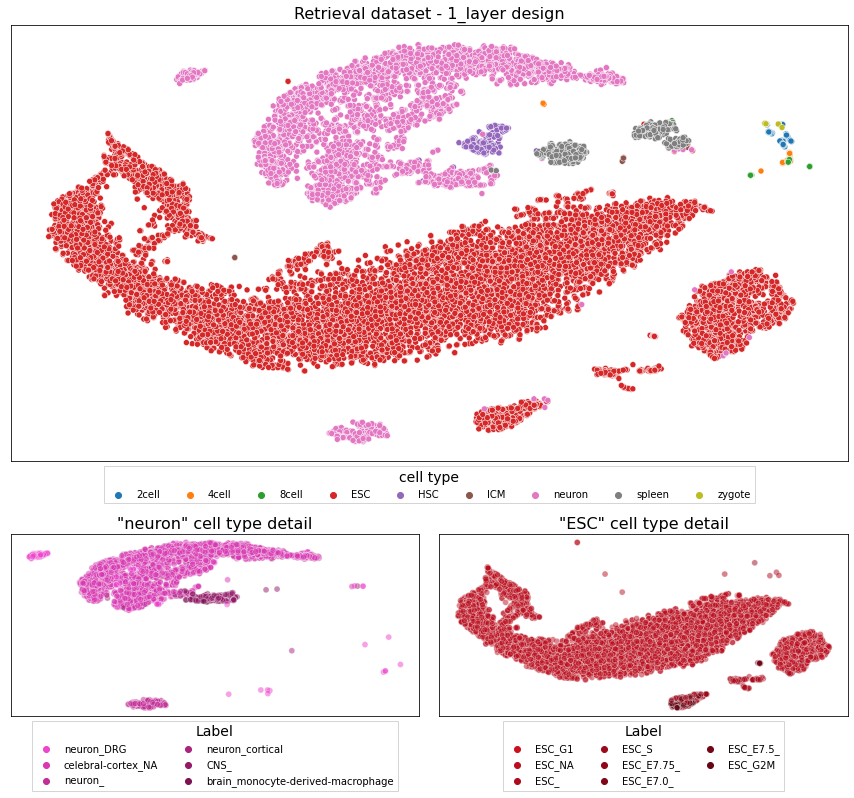

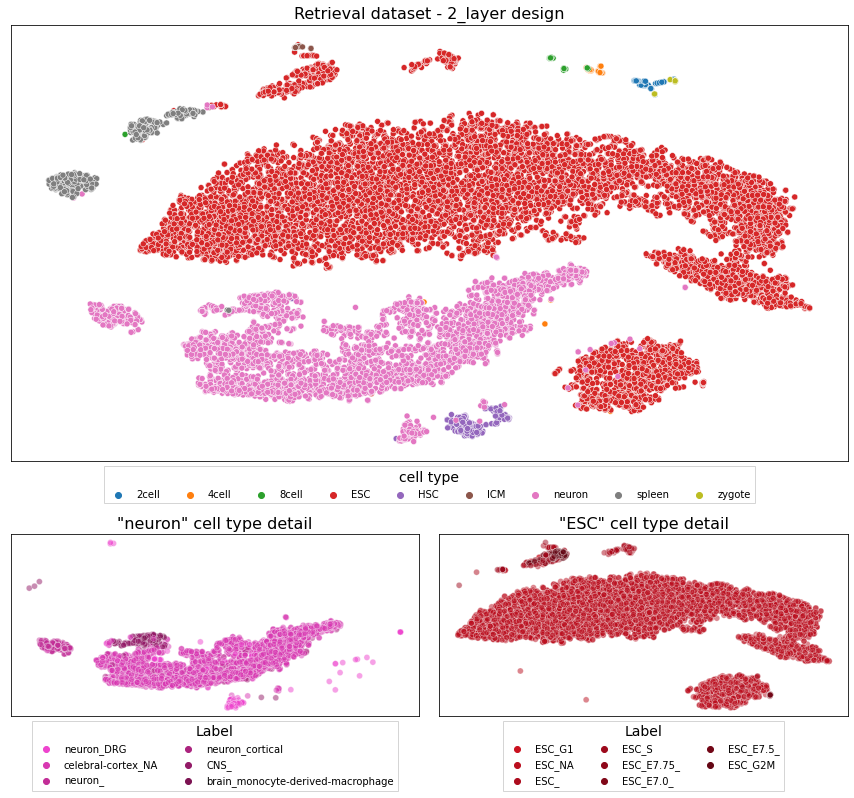

In [8]:
np.random.seed(SEED)
pink_color=['#ee44ce','#d838b2','#c22d97','#ab237e','#931a67','#7c1252']
red_color=['#ca111f','#bb0e1e','#ac0b1d','#9d091c','#8f081a','#800718','#720616','#640614']

for i_design in ['1_layer','2_layer']:

    print(glob.glob(os.path.join(loc_read, f'encoding_{i_design}*'))[0])
    model = keras.models.load_model( glob.glob(os.path.join(loc_read, f'encoding_{i_design}*'))[0] , compile=False)
    encoding = model.predict(X)
    print(i_design)
    
    encoding = model.predict(X)
    tsne = TSNE().fit_transform(encoding)

    df_encoding_tsne = df_encoding_tsne = pd.concat([pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])
                                  , pd.DataFrame(np.array(y_ground_truth),columns=['cell_type'])], axis=1)
    sorter_index=dict(zip(sorted(set(df_retrieval['cell_type'])), range(len(set(df_retrieval['cell_type']))) ))
    df_encoding_tsne['order'] = df_encoding_tsne['cell_type'].map(sorter_index)
    df_encoding_tsne['Label'] = df_retrieval['Label'].values
    df_encoding_tsne
    
    
    fig = plt.figure(figsize=(15,12))
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2, rowspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0), colspan=1)
    ax5 = plt.subplot2grid((3, 2), (2, 1), colspan=1)

    sns.scatterplot(data=df_encoding_tsne.sort_values(by='order')
                    , x='tsne1', y='tsne2', hue='cell_type', ax=ax1, alpha=1., marker="o")
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), title='cell type', fancybox=False, shadow=False, ncol=len(y_ground_truth.unique()));

    sns.scatterplot(data=df_encoding_tsne.loc[df_encoding_tsne['cell_type'].isin(['neuron'])].sort_values(by='order')
                    , x='tsne1', y='tsne2', hue='Label', ax=ax3, alpha=.5, marker="o", palette=pink_color)
    ax3.legend(loc='upper center', bbox_to_anchor=(.5, 0.0), title='Label', fancybox=False, shadow=False, ncol=2, fontsize=SMALL_SIZE)

    sns.scatterplot(data=df_encoding_tsne.loc[df_encoding_tsne['cell_type'].isin(['ESC'])].sort_values(by='order')
                    , x='tsne1', y='tsne2', hue='Label', ax=ax5, alpha=.5, marker="o", palette=red_color)
    ax5.legend(loc='upper center', bbox_to_anchor=(.5, 0.0), title='Label', fancybox=False, shadow=False, ncol=3, fontsize=SMALL_SIZE)

    for axes in [ax1,ax3,ax5]:
        axes.axes.xaxis.set_visible(False)
        axes.axes.yaxis.set_visible(False)

    # fig.suptitle('Neural Network Encoding', fontsize=14)
    ax1.set_title('Retrieval dataset - '+i_design+' design')#, fontdict={'fontsize': 10, 'fontweight': 'medium'})
    ax3.set_title('"neuron" cell type detail')#, fontdict={'fontsize': 10, 'fontweight': 'medium'})
    ax5.set_title('"ESC" cell type detail')#, fontdict={'fontsize': 10, 'fontweight': 'medium'})
    # plt.tight_layout()
    plt.subplots_adjust(left=0.125,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.05, 
                        hspace=0.4)

    plt.savefig(f'./reports/encoding/{experiment}/mouse_enc_'+i_design+'.png', dpi=300, bbox_inches = 'tight')
    plt.savefig(f'./reports/encoding/{experiment}/mouse_enc_'+i_design+'.svg', dpi=300, bbox_inches = 'tight')
    plt.savefig(f'./reports/encoding/{experiment}/mouse_enc_'+i_design+'.pdf', dpi=300, bbox_inches = 'tight')
    

In [ ]:
del(df_retrieval)
del(df_retrieval_org)
del(df_encoding_tsne)
del(X, y_ground_truth)
del(split, experiment, loc_read)

## IMMUNE

In [14]:
split = 'train_test_split'
experiment = 'exper_immune'
loc_read = os.path.join(src.DIR_MODELS, experiment, split)
df_immune = pd.read_pickle('./data/processed/exper_immune/fig3.pck')

X = df_immune.iloc[:, :-1].values
y = df_immune.iloc[:, -1:]
ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(y.values).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=SEED, stratify=y_ohe)
target_y = pd.concat([y_train, y_test])

/home/pgundogdu/projects/signalization_prior_knowledge_based_nn/models/exper_immune/train_test_split/encoding_1_layer_signaling_fig3_Adam_relu.h5
/home/pgundogdu/projects/signalization_prior_knowledge_based_nn/models/exper_immune/train_test_split/encoding_2_layer_signaling_fig3_Adam_relu.h5


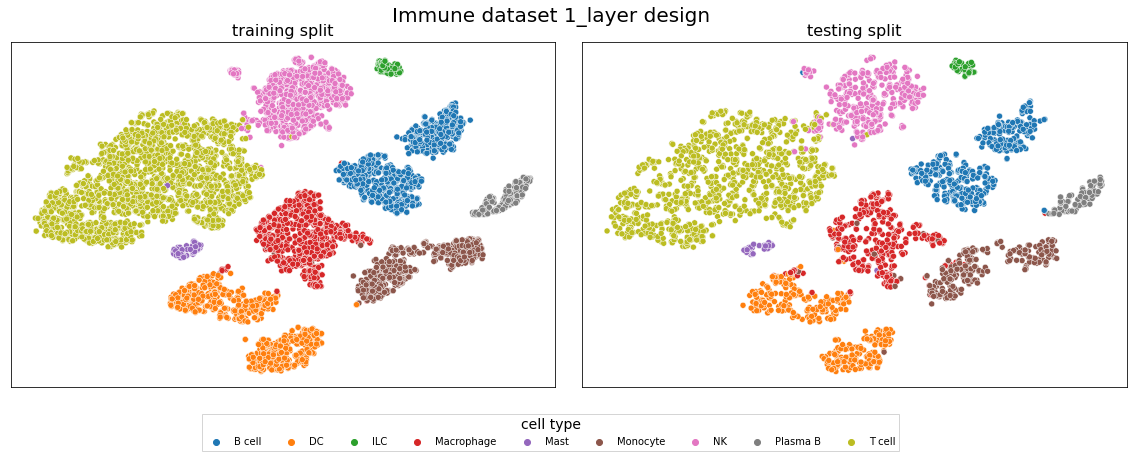

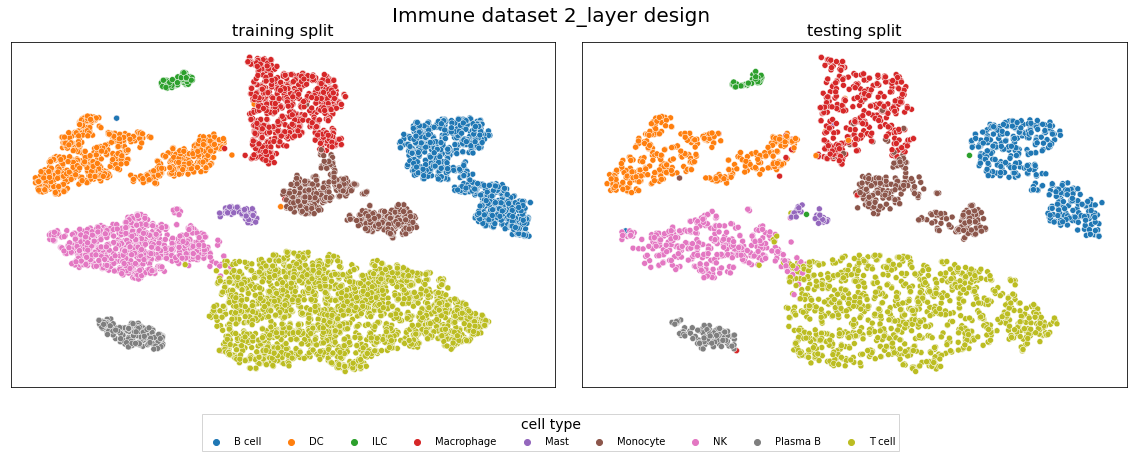

In [16]:
np.random.seed(91)
for i_design in ['1_layer','2_layer']:

    print(glob.glob(os.path.join(loc_read, f'encoding_{i_design}*'))[0])
    model = keras.models.load_model( glob.glob(os.path.join(loc_read, f'encoding_{i_design}*'))[0] , compile=False)
    
    encoding_train = pd.DataFrame(model.predict(X_train))
    encoding_train['training_testing']='training'
    encoding_test = pd.DataFrame(model.predict(X_test))
    encoding_test['training_testing']='testing'
    
    target_y = pd.concat([y_train, y_test])
    
    encoding_comb = pd.concat([encoding_train, encoding_test], axis=0).reset_index(drop=True)
    
    tsne_encoding = TSNE().fit_transform(encoding_comb.iloc[:, :-1])
    
    df_encoding_tsne = pd.concat([pd.DataFrame(tsne_encoding, columns=['tsne1', 'tsne2'])
                              , encoding_comb['training_testing'].reset_index(drop=True)
                              , target_y.reset_index(drop=True)], axis=1)

    
    fig, axes= plt.subplots(ncols=2, figsize=(20,6))
    sns.scatterplot(data=df_encoding_tsne[df_encoding_tsne['training_testing']=='training']
                    , x='tsne1', y='tsne2'
                    , hue='cell_type', ax=axes[0]
                    , hue_order=sorted(set(df_encoding_tsne['cell_type'])))
    axes[0].get_legend().remove()
    axes[0].set_title('training split')

    sns.scatterplot(data=df_encoding_tsne[df_encoding_tsne['training_testing']=='testing']
                    , x='tsne1', y='tsne2'
                    , hue='cell_type', ax=axes[1]
                    , hue_order=sorted(set(df_encoding_tsne['cell_type'])))
    axes[1].get_legend().remove()
    axes[1].set_title('testing split')


    handles, labels = axes[0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc='upper center', title='cell type', bbox_to_anchor=(.5, 0.05), fancybox=False, shadow=False, ncol=9)
    axes[0].axes.get_yaxis().set_visible(False)
    axes[0].axes.get_xaxis().set_visible(False)

    axes[1].axes.get_yaxis().set_visible(False)
    axes[1].axes.get_xaxis().set_visible(False)
    fig.suptitle(f'Immune dataset {i_design} design')
    plt.subplots_adjust(left=0.125,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.05, 
                        hspace=0.4)
    
    # fig.savefig('encoding.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(f'./reports/encoding/{experiment}/immune_enc_'+i_design+'.png', dpi=300, bbox_inches = 'tight')
    plt.savefig(f'./reports/encoding/{experiment}/immune_enc_'+i_design+'.pdf', dpi=300, bbox_inches = 'tight')
    plt.savefig(f'./reports/encoding/{experiment}/immune_enc_'+i_design+'.svg', dpi=300, bbox_inches = 'tight')

In [17]:
del(df_immune)
del(df_encoding_tsne)
del(X,y ,y_ohe)
del(X_train, y_train)
del(X_test, y_test)
del(split, experiment, loc_read)

## PBMC

In [27]:
split = 'train_test_split'
experiment = 'exper_pbmc'
loc_read = os.path.join(src.DIR_MODELS, experiment, f'{split}_hptuner_False')
df_immune = pd.read_pickle('./data/processed/exper_pbmc/pbmc_sw_log1p.pck')

X = df_immune.iloc[:, :-1].values
y = df_immune.iloc[:, -1:]
ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(y.values).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED, stratify=y_ohe)
target_y = pd.concat([y_train, y_test])

/home/pgundogdu/projects/signalization_prior_knowledge_based_nn/models/exper_pbmc/train_test_split_hptuner_False/encoding_1_layer_pathway_signaling_pbmc_sw_log1p_Adam_relu.h5
/home/pgundogdu/projects/signalization_prior_knowledge_based_nn/models/exper_pbmc/train_test_split_hptuner_False/encoding_2_layer_pathway_signaling_pbmc_sw_log1p_Adam_relu.h5


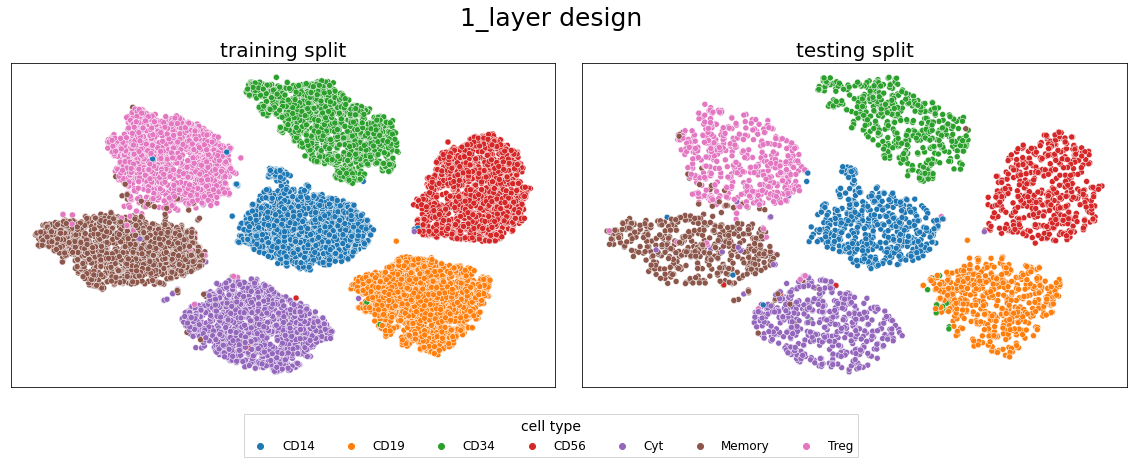

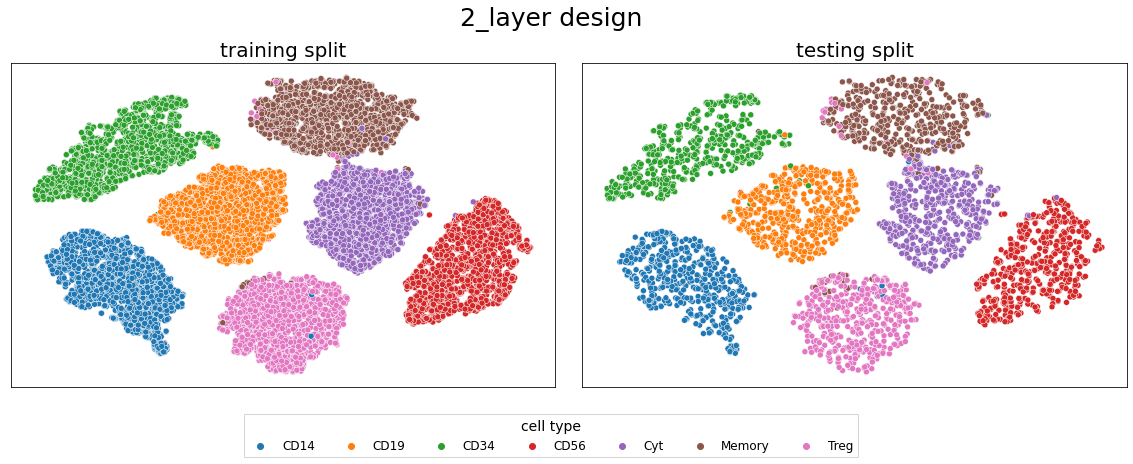

In [36]:
np.random.seed(91)
for i_design in ['1_layer','2_layer']:

    print(glob.glob(os.path.join(loc_read, f'encoding_{i_design}_pathway*'))[0])
    model = keras.models.load_model( glob.glob(os.path.join(loc_read, f'encoding_{i_design}_pathway*'))[0] , compile=False)
    
    encoding_train = pd.DataFrame(model.predict(X_train))
    encoding_train['training_testing']='training'
    encoding_test = pd.DataFrame(model.predict(X_test))
    encoding_test['training_testing']='testing'
    
    target_y = pd.concat([y_train, y_test])
    
    encoding_comb = pd.concat([encoding_train, encoding_test], axis=0).reset_index(drop=True)
    
    tsne_encoding = TSNE().fit_transform(encoding_comb.iloc[:, :-1])
    
    df_encoding_tsne = pd.concat([pd.DataFrame(tsne_encoding, columns=['tsne1', 'tsne2'])
                              , encoding_comb['training_testing'].reset_index(drop=True)
                              , target_y.reset_index(drop=True)], axis=1)

    
    fig, axes= plt.subplots(ncols=2, figsize=(20,6))
    sns.scatterplot(data=df_encoding_tsne[df_encoding_tsne['training_testing']=='training']
                    , x='tsne1', y='tsne2'
                    , hue='cell_type', ax=axes[0], marker="o"
                    , hue_order=sorted(set(df_encoding_tsne['cell_type'])))
    axes[0].get_legend().remove()
    axes[0].set_title('training split')

    sns.scatterplot(data=df_encoding_tsne[df_encoding_tsne['training_testing']=='testing']
                    , x='tsne1', y='tsne2'
                    , hue='cell_type', ax=axes[1], marker="o"
                    , hue_order=sorted(set(df_encoding_tsne['cell_type'])))
    axes[1].get_legend().remove()
    axes[1].set_title('testing split')


    handles, labels = axes[0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc='upper center', title='cell type', bbox_to_anchor=(.5, 0.05), fancybox=False, shadow=False, ncol=9)
    axes[0].axes.get_yaxis().set_visible(False)
    axes[0].axes.get_xaxis().set_visible(False)

    axes[1].axes.get_yaxis().set_visible(False)
    axes[1].axes.get_xaxis().set_visible(False)
    fig.suptitle(f'{i_design} design')
    plt.subplots_adjust(left=0.125,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.85, 
                        wspace=0.05, 
                        hspace=0.4)
    
    # fig.savefig('encoding.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(f'./reports/encoding/{experiment}/pbmc_enc_'+i_design+'.png', dpi=300, bbox_inches = 'tight')
    plt.savefig(f'./reports/encoding/{experiment}/pbmc_enc_'+i_design+'.pdf', dpi=300, bbox_inches = 'tight')
    plt.savefig(f'./reports/encoding/{experiment}/pbmc_enc_'+i_design+'.svg', dpi=300, bbox_inches = 'tight')